In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import defaultdict, Counter
from tools.record_tools import complete_records
from scipy.spatial.distance import jensenshannon
sns.set()

In [2]:
def divergence(df,labels,measure='jensenshannon',target='first_price_int'):

    props_pop, props_sample = [], []

    for label in labels:
        pol_prop = df.groupby([target,'year'])['id'].count() / df.groupby(['year'])['id'].count()
        
        pol_prop_jisc = df[df['IN_JISC']==True].groupby([target,'year'])['id'].count() / df[df['IN_JISC']==True].groupby(['year'])['id'].count()
        
            
        if isinstance(label,list):
            pol_prop = pol_prop.loc[label,:].groupby('year').sum()
            #print(pol_prop)
            try:
                pol_prop_jisc = pol_prop_jisc.loc[label,:].groupby('year').sum()
            except:
                pol_prop_jisc = pd.Series([.0]*len(df.year.unique()),index=df.year.unique())
        else:
            pol_prop = pol_prop.loc[label,:].droplevel(target)
            try:
                pol_prop_jisc = pol_prop_jisc.loc[label,:].droplevel(target)
            except:
                pol_prop_jisc = pd.Series([.0]*len(df.year.unique()),index=df.year.unique())
            
            
        props_pop.append(pol_prop); props_sample.append(pol_prop_jisc) 
    props_pop, props_sample = pd.concat(props_pop, axis=1).fillna(0),pd.concat(props_sample, axis=1).fillna(0)

    scores = {}

    for year in props_pop.index:
        exec(f'scores[year] = {measure}(props_pop.loc[year],props_sample.loc[year])')

    return props_pop,props_sample,pd.DataFrame.from_dict(scores,orient='index')

# Price

In [3]:
df = pd.read_csv('output_data/MPD_export_1846_1920_JISC_ref.csv', index_col=0)
df['IN_JISC'] = False
df.loc[df['JISC'] > 0,'IN_JISC'] = True

In [4]:
df = complete_records(df,'S-POL')

In [7]:
convert_price = {'1d':1, '2d':2 ,'½ d':.5,'3d':3,
    '1 ½ d':1.5, '6d':6,'4d':4, 
    '5d':5, '3 ½ d':3.5, '4 ½ d':4.5,
    '2 ½ d':2.5, '1s':12, 'Gratis':.0, 
    '9d':9, '7d':7, '8d':8, 'gratis':0, 
    '5s':60, '21s':252, '10s':120, '20s':240, 
    '2s':24, '8s':96, '£ 3 3s':756, '12s':144, 
    '1':1,'One Halfpenny':.5, '1 ½':1.5, 
    '26s':312, '7s':84,'½<CON>d':.5, 
    '2':2,'£ 1 12s':384,'24s':288, 
    '3 ½':3.5,'15s':189, 'Halfpenny':.5,
    '£ 1 19s':468,'40s':480,'1 ½ 4':1.5,
    '13s':156, '£ 1 10s':360, '6':6, 
    ' ½ d':.5, '6s':72,'Gra':0, 
    '42s':504,'5 ½ d':5.5,'One Penny':1,
    'Sixpence':72, '£ 2 2s':504, '£2 ':480,
    '4s':48,'£ 1 5s':252,'£ 2 16s':672 ,
    '4 ½':4.5,'3s':36}


df['first_price'] = df['S-PRICE'].apply(lambda x: x.split('<SEP>')[0] if isinstance(x,str) else x)
df['first_price'] = df['first_price'].apply(lambda x: convert_price.get(x,None))
df = complete_records(df,'first_price')


In [8]:
df_with_price = df[~df.first_price.isna()]
df_with_price.shape,df.shape

((42231, 24), (43374, 24))

In [9]:
print((df.shape[0] - df_with_price.shape[0]))
print(((df.shape[0] - df_with_price.shape[0]) / df.shape[0]) * 100) 


1143
2.635219255775349


In [10]:
#df.first_price_int.value_counts()

def reduce_price(x,ceil=True):
    try:
        if float(x) <= 1.0:
            return float(x)
        else:
            if ceil:
                return float(math.ceil(x))
            else:
                return float(x)
    except:
        return None

ceil = True
df_with_price['first_price_red'] = df_with_price.first_price.apply(reduce_price,ceil=ceil)


/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [11]:
df_prov_with_price = df_with_price[df_with_price.CATEGORY.isin(['provincial','welsh','scottish','irish'])]
df_prov_with_price = df_prov_with_price[df_prov_with_price.year <= 1900]


In [12]:
df_prov_with_price.loc[df_prov_with_price['first_price_red'] > 6.0,'first_price_red'] = 6
selected_prices = list(df_prov_with_price.first_price_red.value_counts().index)
selected_prices.sort()

selected_prices

[0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

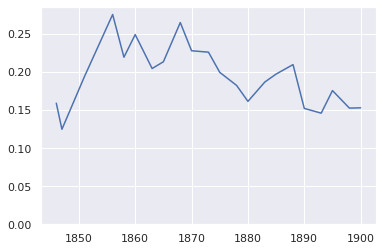

In [13]:
target = 'first_price_red'
props_pop,props_sample,d= divergence(df_prov_with_price,selected_prices,target=target)
fig = d.plot(legend=False,ylim=(.0,max(d.values)[0]+.01)).get_figure()
fig.savefig('images/jsd_price.png')


In [14]:
props_pop.columns = selected_prices
props_sample.columns = selected_prices

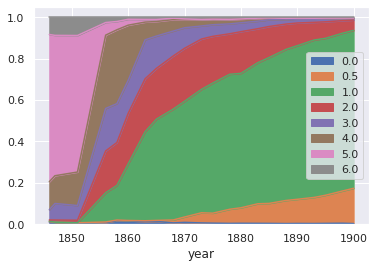

In [15]:
fig = props_pop.plot(kind='area').get_figure()
fig.savefig('images/price_area_pop.png')

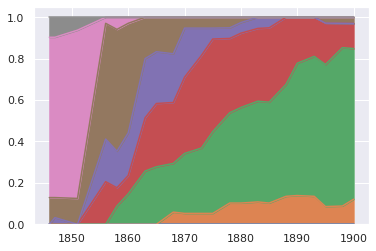

In [16]:
fig = props_sample.plot(kind='area',legend=False).get_figure()
fig.savefig('images/price_area_sample.png')

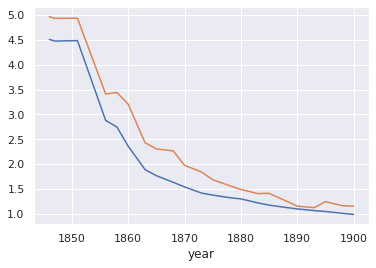

In [17]:
df_prov_with_price[(~df_prov_with_price['first_price'].isnull()) & (df_prov_with_price['first_price'] <= 12.0)].groupby('year')['first_price'].mean().plot()
fig = df_prov_with_price[df_prov_with_price.IN_JISC==True].groupby('year')['first_price_red'].mean().plot().get_figure()
fig.savefig('images/price_avg_comp.png')

In [18]:
labels = selected_prices

props_pop.columns = labels
props_sample.columns = labels

#kl_p = lambda x: x[0] * np.log(2*x[0]/(x[0]+x[1]))
def kl_p(x):
    if x[0]+x[1] > .0:
        return x[0] * np.log(2*x[0]/(x[0]+x[1]))
    else:
        return .0

kl_ps = []
for year in props_pop.index:
    
    kl_ps.append(list(map(kl_p,zip(props_pop.loc[year],props_sample.loc[year]))))

kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
kl_ps_df.index = df_prov_with_price.year.unique()


In [23]:
kl_ps_df.std(axis=0).sort_values()

0.0    0.003053
6.0    0.005391
0.5    0.013710
5.0    0.019963
3.0    0.026489
4.0    0.036790
2.0    0.047743
1.0    0.055442
dtype: float64

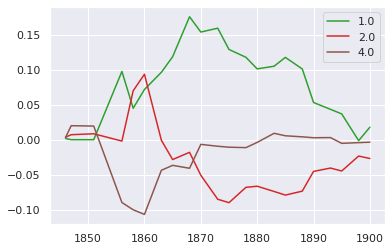

In [30]:
fig = kl_ps_df[[1.0,2.0,4.0]].plot(legend=True, color=['#2ca02c','#d62728','#8c564b']).get_figure()


In [ ]:
fig = kl_ps_df.plot(legend=False, lw=2,
                    style=['.-','.-','.--','.--','.-','.--','.-','.-'],
                    color=['grey','grey','#2ca02c','#d62728','grey','#8c564b','grey','grey']
).get_figure()
fig.savefig('images/partial_price_kl.png')

# Place

In [32]:
df_prov= df[df.CATEGORY.isin(['provincial','welsh','scottish','irish'])]
df_prov = df_prov[df_prov.year <= 1900]

In [33]:
df_prov_gb = df_prov[df_prov.CATEGORY.isin(['provincial','welsh','scottish'])]
counties = df_prov_gb.COUNTY.value_counts()
selected_counties = list(counties[counties > 1].index)
len(counties),len(selected_counties)

(88, 88)

In [34]:
gaz = pd.read_csv('newspaper_metadata/british_isles_gazetteer.csv')
#gaz.head()

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,17,18,29,33,34,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
#gaz.columns

In [36]:
places = [l.split('\t') for l in open('newspaper_metadata/county_names_with_wik.txt','r').read().split('\n')]
places_df = pd.DataFrame(places, columns=['name','wiki'])
#places_df

In [37]:
places_joined_df = places_df.merge(gaz[['wikidata_id','english_label','latitude','longitude']],left_on='wiki',right_on='wikidata_id',how='left')
places_joined_df.shape

(88, 6)

In [38]:
places_joined_df

,name,wiki,wikidata_id,english_label,latitude,longitude
0,buckinghamshire,Q67285329,Q67285329,Buckinghamshire,51.828022,-0.790426
1,oxfordshire,Q67311417,Q67311417,Oxfordshire,51.808471,-1.287156
2,devonshire,Q67393660,Q67393660,Devon,50.752867,-3.817742
3,somersetshire,Q67461071,Q67461071,Somerset,51.149935,-2.878137
4,bedfordshire,Q67387552,Q67387552,Bedfordshire,52.079580,-0.448204
...,...,...,...,...,...,...
83,salop,Q67574371,Q67574371,Shropshire,52.642392,-2.714801
84,isle of wight,Q9679,Q9679,Isle of Wight,50.666667,-1.266667
85,berwickshire,Q786649,Q786649,Berwickshire,55.750000,-2.500000
86,shetland isles,Q47134,Q47134,Shetland Islands,60.303800,-1.268900


In [39]:
#sum(places_joined_df.latitude.isnull())

In [40]:
#df_prov_gb['COUNTY_2'] = df_prov_gb.COUNTY

In [41]:
df_prov_gb_joined = df_prov_gb.merge(places_joined_df,left_on='COUNTY',right_on='name',how='left')

In [42]:
df_prov_gb_joined.head()

,index,id,S-TITLE,S-POL,CATEGORY,DISTRICT,DISTRICT_PUB,COUNTY,S-PRICE,D-EST,...,IN_JISC,value_S-POL_source_idx,first_price,value_first_price_source_idx,name,wiki,wikidata_id,english_label,latitude,longitude
0,129,MPD_1846_129,BUCK'S GAZETTE .,liberal,provincial,aylesbury . — ( buckinghamshire . ),aylesbury,buckinghamshire,4d,"Nov . 17 , 1821",...,False,None,4.0,None,buckinghamshire,Q67285329,Q67285329,Buckinghamshire,51.828022,-0.790426
1,130,MPD_1846_130,BUCK'S HERALD .,conservative,provincial,aylesbury . — ( buckinghamshire . ),aylesbury,buckinghamshire,5d,"Jannary 6 , 1832",...,False,None,5.0,None,buckinghamshire,Q67285329,Q67285329,Buckinghamshire,51.828022,-0.790426
2,131,MPD_1846_131,AYLESBURY NEWS .,liberal,provincial,aylesbury . — ( buckinghamshire . ),aylesbury,buckinghamshire,4d,"December 3 , 1836",...,False,None,4.0,None,buckinghamshire,Q67285329,Q67285329,Buckinghamshire,51.828022,-0.790426
3,132,MPD_1846_132,BANBURY GUARDIAN .,neutral,provincial,banbury . — ( oxfordshire . ),banbury,oxfordshire,5d,"July 6 , 1843",...,False,None,5.0,None,oxfordshire,Q67311417,Q67311417,Oxfordshire,51.808471,-1.287156
4,133,MPD_1846_133,NORTH DEVON ADVERTISER .,conservative,provincial,barnstaple . — ( devonshire . ),barnstaple,devonshire,4d,"June , 1832",...,False,None,4.0,None,devonshire,Q67393660,Q67393660,Devon,50.752867,-3.817742


In [43]:
#county_names = '\n'.join(df_prov_gb.COUNTY.unique())
#with open('newspaper_metadata/county_names.txt','w') as out_doc:
#    out_doc.write(county_names)

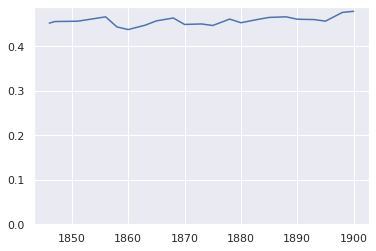

In [44]:
#df_prov_gb.loc[~df_prov_gb['COUNTY'].isin(selected_counties),'COUNTY_2'] = 'other'
selected_counties = df_prov_gb_joined.wikidata_id.unique()
props_pop,props_sample,d= divergence(df_prov_gb_joined,selected_counties,target='wikidata_id')
d.plot(legend=False,ylim=(.0,max(d.values)[0]+.01))


In [45]:
#df_prov_gb[df_prov_gb.COUNTY_2=='other']

In [46]:
#print(selected_counties)

In [47]:
labels = selected_counties

props_pop.columns = labels
props_sample.columns = labels

def kl_p(x):
    if x[0]+x[1] > .0:
        return x[0] * np.log(2*x[0]/(x[0]+x[1]))
    else:
        return .0
        

kl_ps = []
for year in props_pop.index:
    kl_ps.append(list(map(kl_p,zip(props_pop.loc[year],props_sample.loc[year]))))


In [48]:

kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
kl_ps_df.index = props_pop.index
kl_ps_df

,Q67285329,Q67311417,Q67393660,Q67461071,Q67387552,Q67535553,Q67575123,Q67311452,Q67533486,Q163,...,Q100166,Q17582096,Q38825,Q1244778,Q67317108,Q85631961,Q9679,Q786649,Q47134,Q168159
year,,,,,,,,,,,,,,,,,,,,,
1846,0.006665,-0.007851,0.003756,-0.002689,0.004443,-0.005336,0.002043,-0.035683,0.008887,-0.038840,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1847,0.006539,-0.007878,0.005050,-0.001483,0.004359,-0.005490,0.015258,-0.034464,0.013078,-0.036780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1851,0.006438,-0.007048,0.003615,-0.002609,0.004292,-0.005164,0.019314,-0.020655,0.010730,-0.045150,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1856,0.006614,-0.006427,0.001587,-0.000356,0.002646,-0.003028,0.015874,-0.018355,0.019842,-0.040717,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1858,0.007374,-0.006247,0.002171,0.002171,0.004916,-0.003022,-0.002231,-0.016532,0.018435,-0.041774,...,0.001229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1860,0.007052,-0.005817,0.003421,0.002637,0.004030,-0.005345,-0.003688,-0.015353,0.017127,-0.039615,...,0.001007,0.001007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1863,0.006796,-0.005163,0.001423,0.003382,0.003398,-0.005565,-0.002188,-0.014614,0.016139,-0.036266,...,0.001699,0.001699,0.002548,0.000849,0.001699,0.000000,0.000000,0.000000,0.000000,0.000000
1865,0.006224,-0.005993,0.001023,0.002199,0.003890,-0.005343,-0.002754,-0.027070,0.015559,-0.035956,...,0.001556,0.001556,0.001556,0.000778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1868,0.007421,-0.006496,0.000438,-0.000100,0.004453,-0.005912,-0.002153,-0.016872,0.013358,-0.026446,...,0.001484,0.001484,0.001484,0.000742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
kl_ps_df.drop('Q84',inplace=True, axis=1)

In [101]:
#kl_ps_df['hampshire']

In [50]:
to_kepler = kl_ps_df.T
to_kepler['sum'] = to_kepler.sum(axis=1)
to_kepler['mean'] = to_kepler.mean(axis=1)
to_kepler = to_kepler.merge(places_joined_df,left_index=True,right_on='wikidata_id')
to_kepler.columns

Index([           1846,            1847,            1851,            1856,
                  1858,            1860,            1863,            1865,
                  1868,            1870,            1873,            1875,
                  1878,            1880,            1883,            1885,
                  1888,            1890,            1893,            1895,
                  1898,            1900,           'sum',          'mean',
                'name',          'wiki',   'wikidata_id', 'english_label',
            'latitude',     'longitude'],
      dtype='object')

In [51]:
to_kepler['sum_std'] = (to_kepler['sum'] - to_kepler['sum'].mean()) / to_kepler['sum'].std() 
to_kepler['mean_std'] = (to_kepler['mean'] - to_kepler['mean'].mean()) / to_kepler['mean'].std() 

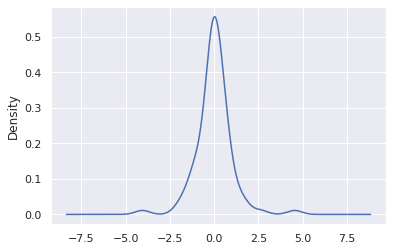

In [52]:
to_kepler['mean_std'].plot(kind='density')

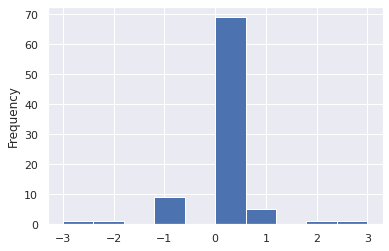

In [53]:
to_kepler['mean_std_int'] = to_kepler['mean_std'].astype(np.int64)
to_kepler.loc[to_kepler['mean_std_int'] >= 3,'mean_std_int'] = 3
to_kepler.loc[to_kepler['mean_std_int'] <= -3,'mean_std_int'] = -3
to_kepler['mean_std_int'].plot(kind='hist')


In [54]:
to_kepler['mean_std_int'].unique()

array([ 0, -1,  1, -3,  2,  3, -2])

In [ ]:
# https://raw.githubusercontent.com/Living-with-machines/MapReader/dev/mapreader/persistent_data/nls_6in_2ed.json?token=ACYUO4HLOEAS45R6VWGYYTTBNUSBM   

In [56]:
to_kepler[['mean','mean_std','mean_std_int','wikidata_id','english_label','latitude','longitude']].to_csv('output_visualisation/kepler_place.csv')

In [151]:

highest_divs = kl_ps_df.abs().sum(axis=0)
sel = highest_divs.sort_values(ascending=False)[:10].index
sel

Index(['Q67479626', 'Q163', 'Q23346', 'Q67574558', 'Q67311452', 'Q67443130',
       'Q67533486', 'Q67531563', 'Q67574715', 'Q67532100'],
      dtype='object')

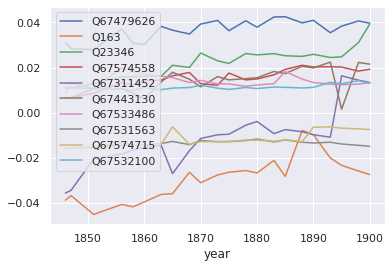

In [152]:
fig = kl_ps_df[sel].plot(legend=True).get_figure()

# Combined

In [23]:
import pickle
df_prov_gb['S-POL-2'] = df_prov_gb['S-POL'].copy()
df_prov_gb['S-POL-2'].fillna('nan',inplace=True)
mapping = pickle.load(open('newspaper_metadata/pol_mapping.pickle','rb'))
df_prov_gb.replace({'S-POL-2':mapping},inplace=True)

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/pandas/core/generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [25]:
df_prov_gb['combined'] = df_prov_gb.apply(lambda x: f'{x["S-POL-2"]}_{x["COUNTY"]}',axis=1)

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


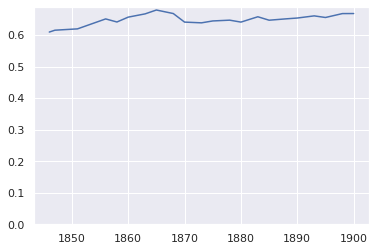

In [26]:
selected = df_prov_gb['combined'].unique()
props_pop,props_sample,d= divergence(df_prov_gb,selected,target='combined')
d.plot(legend=False,ylim=(.0,max(d.values)[0]+.01))


In [27]:
labels = selected

props_pop.columns = labels
props_sample.columns = labels

def kl_p(x):
    if x[0]+x[1] > .0:
        return x[0] * np.log(2*x[0]/(x[0]+x[1]))
    else:
        return .0
        

kl_ps = []
for year in props_pop.index:
    kl_ps.append(list(map(kl_p,zip(props_pop.loc[year],props_sample.loc[year]))))


In [31]:
kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
highest_divs = kl_ps_df.abs().sum(axis=0)
sel = highest_divs.sort_values(ascending=False)[:5].index
sel

Index(['liberal_yorkshire', 'non-aligned_yorkshire', 'non-aligned_lancashire',
       'conservative_lancashire', 'liberal_kent'],
      dtype='object')

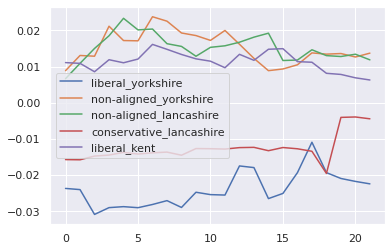

In [32]:
fig = kl_ps_df[sel].plot(legend=True).get_figure()

# Fin.

In [286]:
#df_prov.loc[~df.COUNTY.isin(selected_counties),'COUNTY'] = 'other'

In [287]:
def compute_typicality(selected_county,df,jisc=True):

    def typicality_scores(selected_sample,df_sel):
        results = []
        
        for i,row in selected_sample.iterrows():
            pol = row['S-POL']    
            price = row['first_price_int']
            if pol is np.nan or price is np.nan: continue


            p_a = df_sel[df_sel['S-POL']==pol].shape[0] / df_sel.shape[0]
            p_a_b_nom = df_sel[(df_sel['S-POL']==pol) & (df_sel['first_price_int']==price)].shape[0] 
            p_a_b_denom = df_sel[df_sel['S-POL']==pol].shape[0] 
            p_a_b =  p_a_b_nom / p_a_b_denom
            results.append(p_a*p_a_b)

        return results


    results_general = [] #defaultdict(list)
    results_yearly =  defaultdict(list)

    for year in df.year.unique():

        if year > 1900: continue
        df_sel_county = df[(df.COUNTY==selected_county) & (df.year == year)]
        if df_sel_county.shape[0] <= 0: continue
        
        sample = df_sel_county[~df.JISC.isnull()]
        if sample.shape[0] <= 0: continue
        sample_typ = typicality_scores(sample,df_sel_county)
        for _ in range(100):
            random_sample = df_sel_county.sample(sample.shape[0])
            random_sample_typ = typicality_scores(random_sample,df_sel_county)
            results_general.append(np.nanmean(sample_typ) - np.nanmean(random_sample_typ))
            results_yearly[year].append(np.nanmean(sample_typ) - np.nanmean(random_sample_typ))
        
    results_yearly = {y:np.nanmean(scores) for y, scores in results_yearly.items()}
    return results_general,results_yearly
    


In [251]:

pd.Series(compute_typicality('lancashire',df)[0]).plot(kind='hist',alpha=.5,bins=50)
pd.Series(compute_typicality('oxfordshire',df)[0]).plot(kind='hist',alpha=.75,bins=50)




KeyboardInterrupt: 

In [ ]:
pd.Series(compute_typicality('bedfordshire',df)[1]).plot()
#pd.Series(compute_typicality('devonshire',df)[1]).plot()

In [ ]:
compute_typicality('essex',df)[1]